In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import datetime
%matplotlib inline

In [2]:
def create_table(df, index = "Index", title = None,plot = True):
    value_cells=[df.index]
    for col in df.columns:
        value_cells.append(df[col])
    header = list(df.columns)
    header.insert(0, index)
    table_summ = go.Table(
        header=dict(values=header,
                    fill_color='royalblue',
                    align='center',
                    line_color='darkslategray',
                    font=dict(color='white', size=12),),
        cells=dict(values =value_cells,
                fill_color=['royalblue', 'lavender'],
                line_color='darkslategray',
                font=dict(color=['white','black'], size=12),
                align=['left','center']),
        columnwidth = [200,100])
    fig = go.Figure(data=[table_summ])
    #fig.update_layout(width=800, height=300)
    fig.update_layout(title_text=title)
    if plot:
        fig.show()    
    return fig

In [3]:
def subplot_error(df, title = None):
    x_title = "Y test"
    y_title = "relative error (%)"
    fig = make_subplots(rows=3, cols=1, x_title = "Y test", y_title=y_title, )
    for ng,col in enumerate(df.columns):
        if col != "Y test":
            trace = go.Scatter(x=df['Y test'], y=df[col],mode="markers",name = col)
            fig.update_layout(title_text=title) 
            fig.append_trace(trace,row=ng, col=1)
            fig['layout']['yaxis'+str(ng)].update(title='', range=[0, 200],autorange=False)
    fig.show()

In [4]:
def train_models(X,y,models):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state=42)
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    index = []
    columns_plot=['Y test']
    for m in models:
        ch = str(m)
        pos = ch.find("(")
        ch = ch[:pos]
        index.append(str(m))
        columns_plot.append(ch)
    columns=['Train_r2_score','Test_r2_score','Train_MSE','Test_MSE']
    df_summary=pd.DataFrame(data=None,index=index,columns=columns)
    df_plot=pd.DataFrame(data=None,columns=columns_plot)
    df_plot['Y test'] = y_test.values
    for n,model in enumerate(models):
        model.fit(X_train, y_train)
        y_train_preds = model.predict(X_train)
        y_test_preds = model.predict(X_test)
        score = []
        score.append(np.round(r2_score(y_train, y_train_preds),4))
        score.append(np.round(r2_score(y_test, y_test_preds),4))
        score.append(np.round(mean_squared_error(y_train, y_train_preds),4))
        score.append(np.round(mean_squared_error(y_test, y_test_preds),4))
        df_summary.loc[df_summary.index[n]] = score
        error = (np.abs(y_test-y_test_preds)/y_test)*100
        df_plot.loc[:,df_plot.columns[n+1]] = np.array(error)
    return df_summary, df_plot

In [5]:
df = pd.read_csv('dataset/listings.csv')
df.shape

(3818, 92)

### Preselección de variables

Inicialmente se cuenta con 92 variables, de los cuales se seleccionan las que muestran alguna información,

- Se eliminan las que solo tienen un valor
- Informacion que no es relevante como Codigo de identificación, url, etc
- Las que columnas que solo tienen NaN




In [6]:
columns=['host_since','host_response_rate','host_acceptance_rate','host_is_superhost','host_total_listings_count','host_has_profile_pic','host_identity_verified','latitude','longitude','is_location_exact', 'property_type', 'room_type', 'accommodates','bathrooms', 'bedrooms', 'beds', 'bed_type','amenities','square_feet','price','security_deposit','cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights','maximum_nights', 'calendar_updated', 'has_availability','availability_30', 'availability_60', 'availability_90','availability_365','number_of_reviews','first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location', 'review_scores_value', 'requires_license', 'instant_bookable', 'cancellation_policy', 'require_guest_profile_picture','require_guest_phone_verification', 'calculated_host_listings_count','reviews_per_month']
len(columns)

49

Se eliminan todas las filas con valor NaN de la columna "price", es lo que se va a predecir 

In [7]:
df_1 = df[columns]
df_1 = df_1.dropna(axis = 0, subset=['price'])
df_1.describe()

,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,guests_included,minimum_nights,...,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month
count,3816.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,3817.000000,97.000000,3818.000000,3818.000000,...,3818.000000,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,3818.000000,3191.000000
mean,7.157757,47.628961,-122.333103,3.349398,1.259469,1.307712,1.735394,854.618557,1.672603,2.369303,...,22.223415,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,2.946307,2.078919
std,28.628149,0.043052,0.031745,1.977599,0.590369,0.883395,1.139480,671.404893,1.311040,16.305902,...,37.730892,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,5.893029,1.822348
min,1.000000,47.505088,-122.417219,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,1.000000,0.020000
25%,1.000000,47.609418,-122.354320,2.000000,1.000000,1.000000,1.000000,420.000000,1.000000,1.000000,...,2.000000,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,1.000000,0.695000
50%,1.000000,47.623601,-122.328874,3.000000,1.000000,1.000000,1.000000,750.000000,1.000000,2.000000,...,9.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,1.540000
75%,3.000000,47.662694,-122.310800,4.000000,1.000000,2.000000,2.000000,1200.000000,2.000000,2.000000,...,26.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2.000000,3.000000
max,502.000000,47.733358,-122.240607,16.000000,8.000000,7.000000,15.000000,3000.000000,15.000000,1000.000000,...,474.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,37.000000,12.150000


Se convierte a valor float las columnas donde la información es de moneda:
price, security_deposit, cleaning_fee, extra_people

In [8]:
df_1['price'] = df_1.price.str.replace(",","").str.replace("$","").astype(float)
df_1['security_deposit'] = df_1.security_deposit.str.replace(",","").str.replace("$","").astype(float)
df_1['cleaning_fee'] = df_1.cleaning_fee.str.replace(",","").str.replace("$","").astype(float)
df_1['extra_people'] = df_1.extra_people.str.replace(",","").str.replace("$","").astype(float)
df_1.describe()

,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,price,security_deposit,...,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month
count,3816.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,3817.000000,97.000000,3818.000000,1866.000000,...,3818.000000,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,3818.000000,3191.000000
mean,7.157757,47.628961,-122.333103,3.349398,1.259469,1.307712,1.735394,854.618557,127.976166,287.610397,...,22.223415,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,2.946307,2.078919
std,28.628149,0.043052,0.031745,1.977599,0.590369,0.883395,1.139480,671.404893,90.250022,270.222690,...,37.730892,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,5.893029,1.822348
min,1.000000,47.505088,-122.417219,1.000000,0.000000,0.000000,1.000000,0.000000,20.000000,95.000000,...,0.000000,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,1.000000,0.020000
25%,1.000000,47.609418,-122.354320,2.000000,1.000000,1.000000,1.000000,420.000000,75.000000,150.000000,...,2.000000,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,1.000000,0.695000
50%,1.000000,47.623601,-122.328874,3.000000,1.000000,1.000000,1.000000,750.000000,100.000000,250.000000,...,9.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,1.540000
75%,3.000000,47.662694,-122.310800,4.000000,1.000000,2.000000,2.000000,1200.000000,150.000000,300.000000,...,26.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2.000000,3.000000
max,502.000000,47.733358,-122.240607,16.000000,8.000000,7.000000,15.000000,3000.000000,1000.000000,5000.000000,...,474.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,37.000000,12.150000


Las columnas de información booleana muestran la información True con una 't' y False con una 'f', por lo que se reemplaza 't' por 1 y 'f' por 0 y se jan de tipo float

In [9]:
df_1['host_is_superhost'] = df_1.host_is_superhost.str.replace("t","1").str.replace("f","0").astype(float)
df_1['host_has_profile_pic'] = df_1.host_has_profile_pic.str.replace("t","1").str.replace("f","0").astype(float)
df_1['host_identity_verified'] = df_1.host_identity_verified.str.replace("t","1").str.replace("f","0").astype(float)
df_1['is_location_exact'] = df_1.is_location_exact.str.replace("t","1").str.replace("f","0").astype(float)
df_1['has_availability'] = df_1.has_availability.str.replace("t","1").str.replace("f","0").astype(float)
df_1['requires_license'] = df_1.requires_license.str.replace("t","1").str.replace("f","0").astype(float)
df_1['instant_bookable'] = df_1.instant_bookable.str.replace("t","1").str.replace("f","0").astype(float)
df_1['require_guest_profile_picture'] = df_1.require_guest_profile_picture.str.replace("t","1").str.replace("f","0").astype(float)
df_1['require_guest_phone_verification'] = df_1.require_guest_phone_verification.str.replace("t","1").str.replace("f","0").astype(float)
df_1.describe()

,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,is_location_exact,accommodates,bathrooms,bedrooms,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
count,3816.000000,3816.000000,3816.000000,3816.000000,3818.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,...,3160.000000,3167.000000,3163.000000,3162.000000,3818.0,3818.000000,3818.000000,3818.000000,3818.000000,3191.000000
mean,0.203878,7.157757,0.998166,0.785377,47.628961,-122.333103,0.893662,3.349398,1.259469,1.307712,...,9.786709,9.809599,9.608916,9.452245,0.0,0.154793,0.084075,0.098219,2.946307,2.078919
std,0.402932,28.628149,0.042796,0.410614,0.043052,0.031745,0.308311,1.977599,0.590369,0.883395,...,0.595499,0.568211,0.629053,0.750259,0.0,0.361755,0.277537,0.297649,5.893029,1.822348
min,0.000000,1.000000,0.000000,0.000000,47.505088,-122.417219,0.000000,1.000000,0.000000,0.000000,...,2.000000,2.000000,4.000000,2.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.020000
25%,0.000000,1.000000,1.000000,1.000000,47.609418,-122.354320,1.000000,2.000000,1.000000,1.000000,...,10.000000,10.000000,9.000000,9.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.695000
50%,0.000000,1.000000,1.000000,1.000000,47.623601,-122.328874,1.000000,3.000000,1.000000,1.000000,...,10.000000,10.000000,10.000000,10.000000,0.0,0.000000,0.000000,0.000000,1.000000,1.540000
75%,0.000000,3.000000,1.000000,1.000000,47.662694,-122.310800,1.000000,4.000000,1.000000,2.000000,...,10.000000,10.000000,10.000000,10.000000,0.0,0.000000,0.000000,0.000000,2.000000,3.000000
max,1.000000,502.000000,1.000000,1.000000,47.733358,-122.240607,1.000000,16.000000,8.000000,7.000000,...,10.000000,10.000000,10.000000,10.000000,0.0,1.000000,1.000000,1.000000,37.000000,12.150000


Se pasan a valor numerico las variables que muestran una evalución en porcentaje

In [10]:
df_1['host_response_rate'] = df_1.host_response_rate.str.replace("%","").astype(float)
df_1['host_acceptance_rate'] = df_1.host_acceptance_rate.str.replace("%","").astype(float)
df_1.describe()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,is_location_exact,accommodates,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
count,3295.000000,3045.000000,3816.000000,3816.000000,3816.000000,3816.000000,3818.000000,3818.000000,3818.000000,3818.000000,...,3160.000000,3167.000000,3163.000000,3162.000000,3818.0,3818.000000,3818.000000,3818.000000,3818.000000,3191.000000
mean,94.886798,99.967159,0.203878,7.157757,0.998166,0.785377,47.628961,-122.333103,0.893662,3.349398,...,9.786709,9.809599,9.608916,9.452245,0.0,0.154793,0.084075,0.098219,2.946307,2.078919
std,11.866705,1.812201,0.402932,28.628149,0.042796,0.410614,0.043052,0.031745,0.308311,1.977599,...,0.595499,0.568211,0.629053,0.750259,0.0,0.361755,0.277537,0.297649,5.893029,1.822348
min,17.000000,0.000000,0.000000,1.000000,0.000000,0.000000,47.505088,-122.417219,0.000000,1.000000,...,2.000000,2.000000,4.000000,2.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.020000
25%,98.000000,100.000000,0.000000,1.000000,1.000000,1.000000,47.609418,-122.354320,1.000000,2.000000,...,10.000000,10.000000,9.000000,9.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.695000
50%,100.000000,100.000000,0.000000,1.000000,1.000000,1.000000,47.623601,-122.328874,1.000000,3.000000,...,10.000000,10.000000,10.000000,10.000000,0.0,0.000000,0.000000,0.000000,1.000000,1.540000
75%,100.000000,100.000000,0.000000,3.000000,1.000000,1.000000,47.662694,-122.310800,1.000000,4.000000,...,10.000000,10.000000,10.000000,10.000000,0.0,0.000000,0.000000,0.000000,2.000000,3.000000
max,100.000000,100.000000,1.000000,502.000000,1.000000,1.000000,47.733358,-122.240607,1.000000,16.000000,...,10.000000,10.000000,10.000000,10.000000,0.0,1.000000,1.000000,1.000000,37.000000,12.150000


Se pasa a dias transcurridos las variables "host_since", "first_review" y "last_review"

In [11]:
df_1.host_since=df_1.host_since.apply(lambda x:  abs(datetime.date(2021,2,18)-datetime.date.fromisoformat(str(x))).days if type(x) is str else np.nan) 
df_1.first_review=df_1.first_review.apply(lambda x:  abs(datetime.date(2021,2,18)-datetime.date.fromisoformat(str(x))).days if type(x) is str else np.nan)
df_1.last_review=df_1.last_review.apply(lambda x:  abs(datetime.date(2021,2,18)-datetime.date.fromisoformat(str(x))).days if type(x) is str else np.nan)
df_1.describe()
df_1drop = df_1.copy()

Se genera mapa de calor deacuerdo a la correlación que exixte entre las variable que son de tipo numerico.

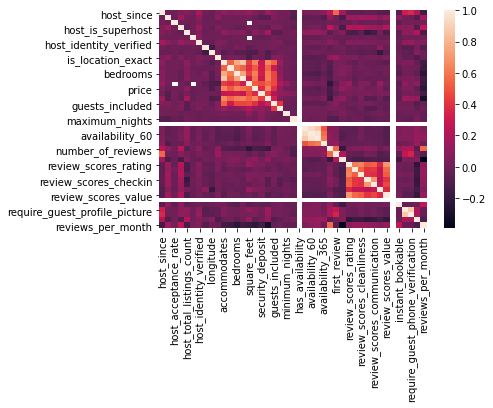

In [12]:
sns.heatmap(df_1drop[df_1drop.columns[0:]].corr(), annot=False, fmt=".1f");

Para una primera aproximación, se van a tener en cuenta las variables que tiene una alta correlación con la variable "price"

In [14]:
to_sel = ['accommodates','bathrooms', 'bedrooms', 'beds','price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people'] 
df_aprox1 = df_1drop.loc[:, to_sel]

Se genera dataset eliminando las filas que tengan al menos un NaN 

In [15]:
df_totrain1 = df_aprox1.dropna(axis = 0, how = 'any')
df_totrain1.describe()

,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people
count,1689.000000,1689.000000,1689.000000,1689.000000,1689.000000,1689.000000,1689.000000,1689.000000,1689.000000
mean,3.848431,1.333629,1.465364,1.971581,145.480166,292.399645,67.898165,2.074600,14.761397
std,2.253381,0.655025,1.026954,1.310872,102.624302,273.171920,48.966308,1.609473,19.127702
min,1.000000,0.000000,0.000000,1.000000,28.000000,95.000000,5.000000,0.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000,85.000000,150.000000,35.000000,1.000000,0.000000
50%,4.000000,1.000000,1.000000,2.000000,115.000000,250.000000,55.000000,2.000000,10.000000
75%,5.000000,1.500000,2.000000,3.000000,170.000000,350.000000,90.000000,2.000000,25.000000
max,16.000000,4.500000,7.000000,15.000000,999.000000,5000.000000,300.000000,13.000000,300.000000


Se crea el dataframe X de caracteristicas el dataframe Y que es la columna del precio nuestro target 

In [16]:
X = df_totrain1.drop(['price'],axis = 1)
y = df_totrain1['price']

Se divide el dataset en los conjuntos de entrenamiento y test, se crea un scaler a partir delos datos de entrenamiento y se normalizan los datos tanto de entrenamiento como de test.

Se crean y entrenan los modelos de regresión lineal, random forest, y SVR. Se comparan con respecto al R2 score

In [17]:
lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=100, criterion = 'mse')
sv_model = SVR(kernel= 'rbf', C= 1000, gamma= 0.01, epsilon=1, cache_size = 500)
models = [lr_model, rf_model, sv_model]
df_summ1, df_plot1 =train_models(X,y,models)
fig_summary1 = create_table(df_summ1, index = "Model", title = "First aproximation Summary",plot = True)


In [18]:
fig_plot1=subplot_error(df_plot1, title = "Relative error for First aprox")

Ahora, para una segunda aproximación, se genera dataset con todas la variable numéricas preseleccionadas con valores numericos y se eliminan las filas que tengan al menos un NaN 

In [19]:
to_sel = ['accommodates','bathrooms', 'bedrooms', 'beds','price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people'] 
df_aprox2 = df_1drop.loc[:, to_sel]
df_totrain2 = df_aprox2.apply(lambda x: x.fillna(x.mean()),axis=0)
df_totrain2.describe()

,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people
count,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000
mean,3.349398,1.259469,1.307712,1.735394,127.976166,287.610397,61.710904,1.672603,10.667627
std,1.977599,0.589130,0.882700,1.139330,90.250022,188.886166,41.725079,1.311040,17.585922
min,1.000000,0.000000,0.000000,1.000000,20.000000,95.000000,5.000000,0.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000,75.000000,250.000000,35.000000,1.000000,0.000000
50%,3.000000,1.000000,1.000000,1.000000,100.000000,287.610397,61.710904,1.000000,0.000000
75%,4.000000,1.000000,2.000000,2.000000,150.000000,287.610397,65.000000,2.000000,20.000000
max,16.000000,8.000000,7.000000,15.000000,1000.000000,5000.000000,300.000000,15.000000,300.000000


In [20]:
X2 = df_totrain2.drop(['price'],axis = 1)
y2 = df_totrain2['price']

In [21]:
lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=100, criterion = 'mse')
sv_model = SVR(kernel= 'rbf', C= 1000, gamma= 0.01, epsilon=1, cache_size = 500)
models = [lr_model, rf_model, sv_model]
df_summ2, df_plot2 =train_models(X2,y2,models)
fig_summary2 = create_table(df_summ2, index = "Model", title = "Second aproximation Summary",plot = True)

In [22]:
fig_plot2=subplot_error(df_plot2, title = "Relative error for Second aprox")

Tercera aproximación: se genera dataset con todas la variable numéricas preseleccionadas con valores numericos y se rellenan los valores NaN por la media de su respectiva variable

In [26]:
numeric_cols = df_1drop[df_1drop.columns].describe()
df_aprox3 = df_1drop[numeric_cols.columns]
df_totrain3 = df_aprox3.apply(lambda x: x.fillna(x.mean()),axis=0)
X3 = df_totrain3.drop(['price'],axis = 1)
y3 = df_totrain3['price']


In [27]:

lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=100, criterion = 'mse')
sv_model = SVR(kernel= 'rbf', C= 1000, gamma= 0.01, epsilon=1, cache_size = 500)
models = [lr_model, rf_model, sv_model]
df_summ3, df_plot3 =train_models(X3,y3,models)
fig_summary3 = create_table(df_summ3, index = "Model", title = "Third aproximation Summary",plot = True)

In [28]:
fig_plot3=subplot_error(df_plot3, title = "Relative error for Second aprox")

Cambiando las variables categoricas a numéricas

In [29]:
cat_vars_int = df_1drop.select_dtypes(include=['object']).copy().columns
df_cat = df_1drop.copy()
for var in  cat_vars_int:
    # for each cat add dummy var, drop original column
    df_cat = pd.concat([df_cat.drop(var, axis=1), pd.get_dummies(df_cat[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)


In [30]:
df_totrain4 = df_cat.apply(lambda x: x.fillna(x.mean()),axis=0)
df_totrain4.describe()

,host_since,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,is_location_exact,...,calendar_updated_7 months ago,calendar_updated_7 weeks ago,calendar_updated_8 months ago,calendar_updated_9 months ago,calendar_updated_a week ago,calendar_updated_never,calendar_updated_today,calendar_updated_yesterday,cancellation_policy_moderate,cancellation_policy_strict
count,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,...,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000
mean,2709.273585,94.886798,99.967159,0.203878,7.157757,0.998166,0.785377,47.628961,-122.333103,0.893662,...,0.006024,0.016501,0.003667,0.001833,0.064955,0.006286,0.184914,0.060503,0.327658,0.371137
std,569.645825,11.023789,1.618332,0.402827,28.620648,0.042785,0.410507,0.043052,0.031745,0.308311,...,0.077391,0.127408,0.060451,0.042785,0.246480,0.079045,0.388278,0.238447,0.469421,0.483172
min,1873.000000,17.000000,0.000000,0.000000,1.000000,0.000000,0.000000,47.505088,-122.417219,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2227.000000,94.886798,100.000000,0.000000,1.000000,1.000000,1.000000,47.609418,-122.354320,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2625.000000,100.000000,100.000000,0.000000,1.000000,1.000000,1.000000,47.623601,-122.328874,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3107.000000,100.000000,100.000000,0.000000,3.000000,1.000000,1.000000,47.662694,-122.310800,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,4483.000000,100.000000,100.000000,1.000000,502.000000,1.000000,1.000000,47.733358,-122.240607,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [33]:
X4 = df_totrain4.drop(['price'],axis = 1)
y4 = df_totrain4['price']
lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=100, criterion = 'mse')
sv_model = SVR(kernel= 'rbf', C= 1000, gamma= 0.001, epsilon=1, cache_size = 500)
models = [lr_model, rf_model, sv_model]
df_summ4, df_plot4 =train_models(X4,y4,models)
fig_summary4 = create_table(df_summ4, index = "Model", title = "Third aproximation Summary",plot = True)

In [34]:
def find_optimal_lm_mod(X, y, cutoffs, models):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    
    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:
        
        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        df_summ, df_plot = train_models(reduce_X,y,models)
        r2_scores_test.append(list(df_summ.Test_r2_score.values))
        r2_scores_train.append(list(df_summ.Train_r2_score.values))
    return num_feats, r2_scores_test, r2_scores_train

In [97]:
cutoffs = [200000,150000,100000,75000,50000,35000,20000,10000,5000, 3500, 2500, 1000, 100, 50, 30, 20, 10, 5, 3,2,1,0]
lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=100, criterion = 'mse',n_jobs=-1, verbose=1)
sv_model = SVR(kernel= 'rbf', C= 1000, gamma= 0.001, epsilon=1, cache_size = 500)
models = [lr_model,sv_model,rf_model]
num_feats, r2_scores_test, r2_scores_train = find_optimal_lm_mod(X4, y4, cutoffs, models)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0

In [99]:

scores_test = np.array(r2_scores_test)
scores_train = np.array(r2_scores_train)
models_names = ["Linear regresion", "SVM", "Random Forest Regresor"]
x_title = "n features"
y_title = "r2 score"
fig = make_subplots(rows=3, cols=1, x_title = "n Features", y_title="r2 score", )
for ng in range(3):
    trace = go.Scatter(x=num_feats, y=scores_test[:,ng],mode="lines+markers",name = "Test "+models_names[ng])
    fig.append_trace(trace,row=ng+1, col=1)
    trace = go.Scatter(x=num_feats, y=scores_train[:,ng],mode="lines+markers",name = "Train "+models_names[ng])
    fig.update_layout(title_text="Scores") 
    fig.append_trace(trace,row=ng+1, col=1)
    fig['layout']['yaxis'+str(ng+1)].update(title='', range=[0, 1],autorange=False)
    fig['layout']['xaxis'+str(ng+1)].update(title='', range=[0, 3500],autorange=False)
fig.show()

In [65]:
temp= np.array(r2_scores_test)
list(temp[:,0])

[0.546,
 0.5736,
 0.574,
 0.5978,
 0.6157,
 0.6174,
 0.6173,
 0.6177,
 0.6153,
 0.6102,
 0.6046,
 0.5991,
 -1.6975279560811261e+21,
 -2.9434113601266087e+26]

In [25]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

In [33]:
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)


In [28]:
parameters = {'kernel':('linear', 'rbf','Polynomial'), 'C':[0.1,1, 10, 100,1000,10000],                        'gamma':[0.01,0.1,1, 10, 100], 'degree':[2,3,4],
             'epsilon' : [0.001, 0.01, 0.1,1, 10, 100], 'cache_size' : [500]}
model = SVR()
clf = GridSearchCV(estimator=model, param_grid=parameters, n_jobs=4, verbose = 2)

In [29]:
clf.fit(X3_train, y3_train)

Fitting 5 folds for each of 1620 candidates, totalling 8100 fits


GridSearchCV(estimator=SVR(), n_jobs=4,
             param_grid={'C': [0.1, 1, 10, 100, 1000, 10000],
                         'cache_size': [500], 'degree': [2, 3, 4],
                         'epsilon': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.01, 0.1, 1, 10, 100],
                         'kernel': ('linear', 'rbf', 'Polynomial')},
             verbose=2)

In [30]:
pd.DataFrame(clf.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_cache_size,param_degree,param_epsilon,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.267085,0.015025,0.035705,0.004155,0.1,500,2,0.001,0.01,linear,"{'C': 0.1, 'cache_size': 500, 'degree': 2, 'ep...",0.472242,0.426879,0.461401,0.559631,0.547520,0.493535,0.051404,466
1,0.344677,0.018135,0.200862,0.013300,0.1,500,2,0.001,0.01,rbf,"{'C': 0.1, 'cache_size': 500, 'degree': 2, 'ep...",-0.041808,-0.006405,0.000539,0.005413,-0.043564,-0.017165,0.021181,850
2,0.001397,0.000490,0.000000,0.000000,0.1,500,2,0.001,0.01,Polynomial,"{'C': 0.1, 'cache_size': 500, 'degree': 2, 'ep...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1343
3,0.267084,0.009300,0.034110,0.001323,0.1,500,2,0.001,0.1,linear,"{'C': 0.1, 'cache_size': 500, 'degree': 2, 'ep...",0.472242,0.426879,0.461401,0.559631,0.547520,0.493535,0.051404,466
4,0.342085,0.015931,0.209439,0.015020,0.1,500,2,0.001,0.1,rbf,"{'C': 0.1, 'cache_size': 500, 'degree': 2, 'ep...",-0.104754,-0.060184,-0.049390,-0.054593,-0.113124,-0.076409,0.026909,979


In [100]:
a = 1


In [101]:
a

1